<a href="https://colab.research.google.com/github/bt22dr/deep-learning-papers/blob/master/code/cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고한 소스
 * https://arxiv.org/pdf/1711.10604.pdf
 * https://danijar.com/building-variational-auto-encoders-in-tensorflow/
 * https://github.com/hwalsuklee/tensorflow-generative-model-collections/blob/master/VAE.py
 * https://github.com/altosaar/variational-autoencoder

In [1]:
!pip install imageio

In [2]:
%matplotlib inline

import os
import sys
import glob
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

import PIL
import imageio
from IPython import display

import tensorflow as tf
tfd = tf.contrib.distributions

print(tf.__version__)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

1.13.0-rc0


In [0]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], -1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], -1).astype('float32')

train_images = train_images / 255.
test_images = test_images / 255.

![큰 그림에서의 각 모듈간의 관계도](https://github.com/bt22dr/deep-learning-papers/blob/master/code/images/vae/modules.png?raw=1)

출처: Variational Inference and Deep Learning: A New Synthesis

In [0]:
def encoder(x, z_dim=100, n_units=256):
    h1 = tf.layers.dense(x, n_units, activation=tf.nn.leaky_relu)
    h2 = tf.layers.dense(h1, n_units, activation=tf.nn.leaky_relu)
    
    mu = tf.layers.dense(h2, z_dim, activation=None)
    sigma = tf.layers.dense(h2, z_dim, activation=tf.nn.softplus)

    return mu, sigma

In [0]:
def decoder(z, n_units=256):
    h1 = tf.layers.dense(z, n_units, activation=tf.nn.leaky_relu)
    h2 = tf.layers.dense(h1, n_units, activation=tf.nn.leaky_relu)
    x = tf.layers.dense(h2, x_dim, activation=None) # tf.nn.sigmoid

    return x

In [0]:
encoder = tf.make_template('encoder', encoder)
decoder = tf.make_template('decoder', decoder)

In [0]:
x_dim = 28*28
z_dim = 2
inputs_x = tf.placeholder(tf.float32, (None, x_dim), name='input_x')
inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')

![architecture](https://github.com/bt22dr/deep-learning-papers/blob/master/code/images/vae/architecture01.png?raw=1)

![architecture](https://github.com/bt22dr/deep-learning-papers/blob/master/code/images/vae/architecture02.png?raw=1)

In [9]:
# posterior, q(z|x), encoder
q_mu, q_sigma = encoder(inputs_x, z_dim=z_dim)
q_z_given_x = tfd.MultivariateNormalDiag(q_mu, q_sigma)
z_samples = q_z_given_x.sample()

# likelihood, p(x|z), decoder
p_x_given_z_logits = decoder(z_samples)
p_x_given_z = tfd.Bernoulli(logits=p_x_given_z_logits)

# prior, p(z), standard distribution
p_z = tfd.MultivariateNormalDiag(np.zeros(z_dim, dtype=np.float32))

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). 

In [10]:
# visualization

sample_dim = 10
z_samples_stddist = tf.constant(np.random.normal(0, 1, size=(10, 2)), dtype="float32")

p_x_given_z_logits_from_stddist = decoder(z_samples_stddist)
p_x_given_z_stddist = tfd.Bernoulli(logits=p_x_given_z_logits_from_stddist)
p_x_given_z_stddist_mean = tfd.Independent(p_x_given_z_stddist).mean()
p_x_given_z_stddist_sample = p_x_given_z_stddist.sample()

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


![ELBO equation](https://github.com/bt22dr/deep-learning-papers/blob/master/code/images/vae/elbo_equation.png?raw=1)

In [11]:
divergence = tf.reduce_sum(tfd.kl_divergence(q_z_given_x, p_z))
likelihood = tf.reduce_sum(p_x_given_z.log_prob(inputs_x))
elbo = tf.reduce_mean(-divergence + likelihood)

optimizer = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(-elbo)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
Use tf.cast instead.


In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(100).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(10000).batch(10).repeat()

iterator = train_dataset.make_one_shot_iterator()
next_element = iterator.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [0]:
def generate_and_save_images(epoch, itr, np_z, np_x_mean):
  fig = plt.figure(figsize=(11,1))
  
  ax1 = plt.subplot(1, 11, 1)
  ax1.scatter(np_z[:, 0], np_z[:, 1], s=2, c=test_labels, alpha=0.1, cmap='tab10')
  ax1.set_aspect('equal')
  ax1.set_xlim(-4, 4)
  ax1.set_ylim(-4, 4)
  ax1.tick_params(axis='both', which='both', left='off', bottom='off', labelleft='off', labelbottom='off')
  
  for i, sample in enumerate(np.reshape(np_x_mean, (-1,28,28))):
    plt.subplot(1, 11, i+2)
    plt.imshow(sample, cmap='gray')
    plt.axis('off')
    
  plt.savefig('image_at_epoch_{:04d}_{:04d}.png'.format(epoch, itr))
  plt.show()

In [0]:
!rm -rf *.png *.gif

In [15]:
!ls

MNIST_data  sample_data


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


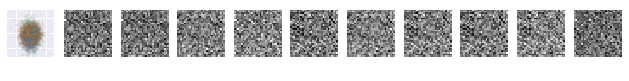

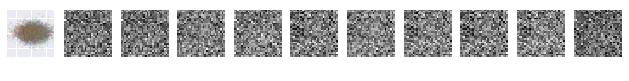

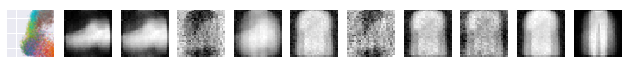

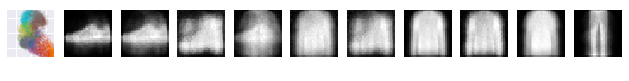

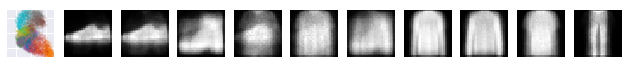

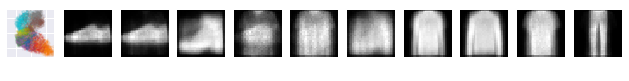

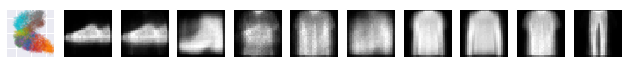

Epoch  0: 26243.393


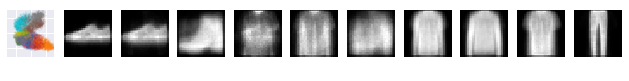

Epoch  1: 27353.12


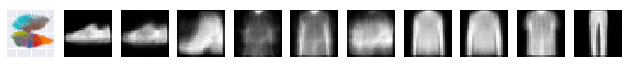

Epoch  2: 27604.61


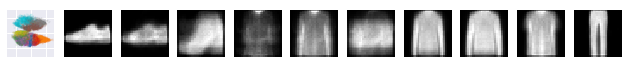

Epoch  3: 27065.273


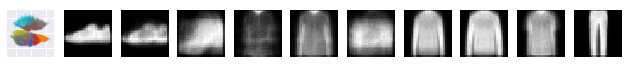

Epoch  4: 27275.94


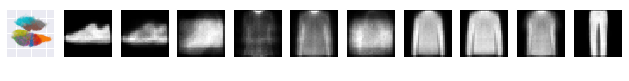

Epoch  5: 26274.65


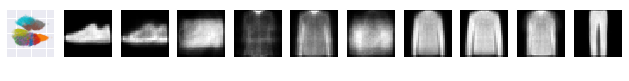

Epoch  6: 26538.24


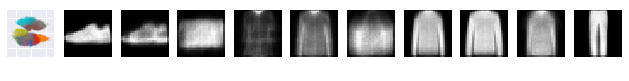

Epoch  7: 27081.293


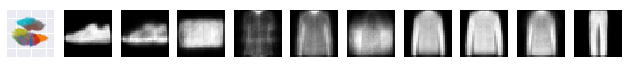

Epoch  8: 26781.098


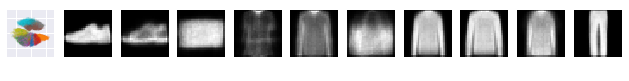

Epoch  9: 26434.826


In [16]:
num_epochs = 10
batch_size = 100

sess = tf.Session()
sess.run(tf.global_variables_initializer())

samples_std_dist = np.random.normal(0, 1, (sample_dim, z_dim)).astype(np.float32)
for epoch in range(num_epochs):
    x_test = test_images
    feed = {inputs_x: x_test, inputs_z: samples_std_dist}
    np_z, np_x_mean = sess.run([z_samples, p_x_given_z_stddist_mean], feed)
    
    generate_and_save_images(epoch, 0, np_z, np_x_mean)

    for ii in range(len(train_images)//batch_size):
        x_train = sess.run(next_element)
        np_elbo,_ = sess.run([elbo, optimizer], feed_dict={inputs_x: x_train})
        if epoch == 0 and ii % 100 == 0: 
          np_z, np_x_mean = sess.run([z_samples, p_x_given_z_stddist_mean], feed)
          generate_and_save_images(epoch, ii, np_z, np_x_mean)
    print("Epoch {:2}:".format(epoch), -np_elbo)

In [17]:
with imageio.get_writer('cvae.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp cvae.gif cvae.gif.png')

0

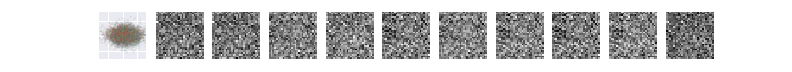

In [18]:
display.Image(filename="cvae.gif.png")

In [0]:
# from google.colab import files
# files.download('cvae.gif')

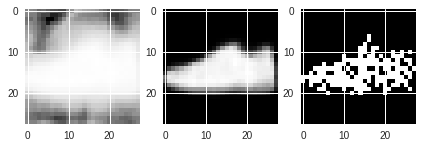

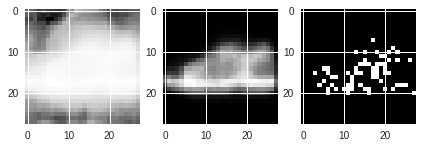

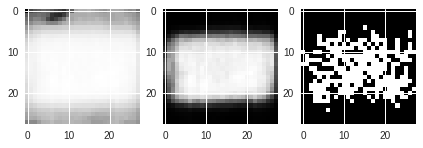

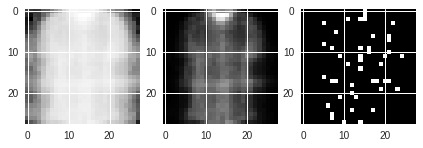

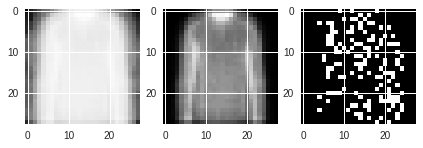

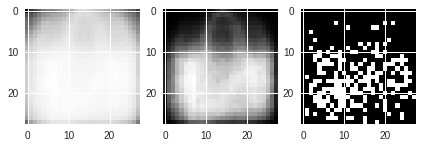

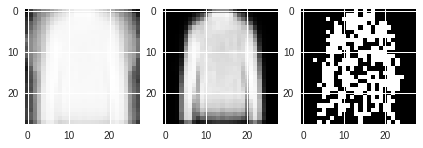

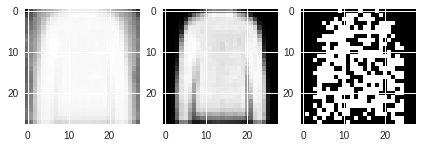

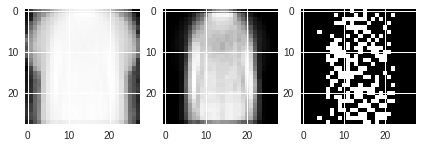

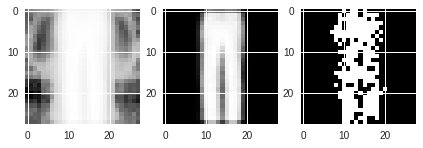

In [20]:
x_test = test_images
samples_std_dist = np.random.normal(0, 1, (sample_dim, z_dim)).astype(np.float32)
np_x_logit, np_x_mean, np_x_sample = sess.run(
    [p_x_given_z_logits_from_stddist, p_x_given_z_stddist_mean, p_x_given_z_stddist_sample], 
    feed_dict={inputs_x: x_test, inputs_z: samples_std_dist})

for i in range(10): # range(mnist.test.num_examples):
    x_logit = np.reshape(np_x_logit[i], (28,28))
    x_mean = np.reshape(np_x_mean[i], (28,28))
    x_sample = np.reshape(np_x_sample[i], (28,28))
    fig_tmp = plt.figure(figsize=(7,4))
    ax_tmp = fig_tmp.add_subplot(131)
    plt.imshow(x_logit, cmap='Greys_r')
    ax_tmp = fig_tmp.add_subplot(132)
    plt.imshow(x_mean, cmap='Greys_r')
    ax_tmp = fig_tmp.add_subplot(133)
    plt.imshow(x_sample, cmap='Greys_r')    